# NLSA Application with batches on 30 years of Daily data

All functions used in this notebook are in the /scripts folder

In [1]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scripts.helper as helper
import scripts.matrix_helper as mat_helper
from tqdm import tqdm_notebook
from scipy import signal
from scipy.sparse import vstack
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import identity
from scipy.sparse import diags

from mpl_toolkits.basemap import Basemap

#Cool stuff -> Every notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [27]:
D = np.load('Daily_D_Mat_5y.npy', mmap_mode='r')

In [28]:
batch_size = 3000
n_batches = int(np.floor(D.shape[0] / batch_size)) + 1
print(n_batches)

4


In [8]:
for b in range(n_batches):
    id_lim = min((b+1)*batch_size, D.shape[0])
    np.save('30y_D_' + str(b), D[b*batch_size:id_lim])

In [32]:
x = np.load('30y_D_3.npy', mmap_mode='r')
x.shape

(499, 9499)

### Compute Phis

In [73]:
def precompute_phi_batches(name, n_batches, batch_size):
    res = []
    res.append(1.0)
    for b in tqdm_notebook(range(n_batches)):
        d0 = np.load(name + str(b) + '.npy', mmap_mode='r')
        for i in range(1, batch_size+1):
            if i + (b*batch_size) >= d0.shape[1]:
                continue
            else:
                res.append(d0[i-1, i + (b*batch_size)])
    np.save('30y_phi_vector', res)

In [74]:
precompute_phi_batches('30y_D_', 4, batch_size)

A Jupyter Widget

### Select K-Closest indexes Batch

In [78]:
## VOIR POUR SYM
def select_k_closest_batches(name, n_batches, k):
    for b in tqdm_notebook(range(n_batches)):
        d0 = np.load(name + str(b) + '.npy')
        res = np.zeros(d0.shape)
        dim = d0.shape[0]
        for i in range(dim):
            k_indx = sorted(np.argpartition(d0[i], k)[1:k+1])
            res[i, k_indx] = d0[i, k_indx]       
        np.save('30y_k_closest_' + str(b), res)

In [79]:
select_k_closest_batches('30y_D_', n_batches, 2000)

A Jupyter Widget

In [35]:
def rebuild_sparse(name, n_batches):
    res = lil_matrix([0, 0])
    for b in tqdm_notebook(range(n_batches)):
        dist_mat = np.load(name + str(b) + '.npy', mmap_mode='r')
        if b == 0:
            res = lil_matrix(dist_mat)
        else:
            res = vstack([res, lil_matrix(dist_mat)])
    return res

In [36]:
x = rebuild_sparse('30y_D_', n_batches)

A Jupyter Widget

In [37]:
check_symmetric(x.todense())

True

### NLSA Kernel with Sparse Matrix

In [38]:
def build_nlsa_kernel_batches(name, n_batches, b_size, eps):
    phi_vec = np.load('30y_phi_vector.npy', mmap_mode='r')
    for b in tqdm_notebook(range(n_batches)):
        dist_mat = np.load(name + str(b) + '.npy', mmap_mode='r')
        row, col = dist_mat.shape
        dist_mat = np.power(dist_mat, 2)
        for i in range(row):
            di = phi_vec[i +  (b * b_size)]
            for j in range(col):  
                dj = phi_vec[j]
                dist_mat[i, j] = dist_mat[i, j] / (di*dj)
        
        indx = np.nonzero(dist_mat)
        dist_mat[indx] = np.exp(-dist_mat[indx]/eps)
        if b == 0:
            np.save('30y_nlsa_kernel_' + str(b), dist_mat[1:, 1:])
        else:
            np.save('30y_nlsa_kernel_' + str(b), dist_mat[:, 1:])

In [39]:
build_nlsa_kernel_batches('30y_D_', n_batches, batch_size, 2.0)

A Jupyter Widget

In [44]:
test = np.load('30y_nlsa_kernel_0.npy')

In [45]:
test.shape

(2999, 9498)

In [46]:
test[0, :]

array([ 0.        ,  0.60656713,  0.33717955, ...,  0.08130636,
        0.08270094,  0.08331163])

### Rebuild full sparse matrix

In [47]:
def rebuild_sparse_K(name, n_batches):
    res = lil_matrix([0, 0])
    for b in tqdm_notebook(range(n_batches)):
        dist_mat = np.load(name + str(b) + '.npy', mmap_mode='r')
        if b == 0:
            res = lil_matrix(dist_mat)
        else:
            res = vstack([res, lil_matrix(dist_mat)])
    save_npz('30y_K_sparse.npz', res)

In [48]:
rebuild_sparse_K('30y_nlsa_kernel_', n_batches)

A Jupyter Widget

In [17]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

### Laplace-Beltrami Operator (fast)

In [49]:
nlsa_kernel = load_npz('30y_K_sparse.npz')

In [50]:
nlsa_kernel.shape

(9498, 9498)

In [51]:
check_symmetric(nlsa_kernel.todense())

True

In [52]:
def build_Laplace_Beltrami_operator_sparse_fast(kernel_mat):
    #Equivalent to kernel_mat = csr_matrix(kernel_mat / (kernel_mat.sum(axis=1)[:, None] * kernel_mat.sum(axis=0)[None, :]))
    # This should stay sparse and fit in memory
    d = diags(1/kernel_mat.sum(axis=1).A.ravel())
    e = diags(1/kernel_mat.sum(axis=0).A.ravel())
    kernel_mat = d @ kernel_mat
    kernel_mat = kernel_mat @ e
    # Equivalent to kernel_mat = kernel_mat / kernel_mat.sum(axis=1)
    # This should stay sparse and fit in memory
    c = diags(1/kernel_mat.sum(axis=1).A.ravel())
    kernel_mat = c @ kernel_mat
    # P = I - K
    kernel_mat = identity(kernel_mat.shape[0]) - kernel_mat
    return kernel_mat

In [53]:
L = build_Laplace_Beltrami_operator_sparse_fast(nlsa_kernel)

In [54]:
L.shape

(9498, 9498)

In [55]:
type(L)

scipy.sparse.csr.csr_matrix

In [56]:
check_symmetric(L.todense())

False

In [57]:
L.data

array([-0.01264977, -0.00700551, -0.00485794, ..., -0.00599722,
       -0.01079649,  1.        ])

In [58]:
# Eigendecomposition of the Laplacian - keep only the real part
w_k, v_k = eigs(L, k=100, which='SM')
w_k = np.real(w_k)
v_k = np.real(v_k)

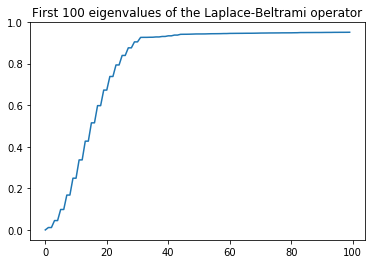

In [59]:
# Eigenvalue plot
plt.title('First 100 eigenvalues of the Laplace-Beltrami operator')
plt.plot(w_k[:100])
plt.show()

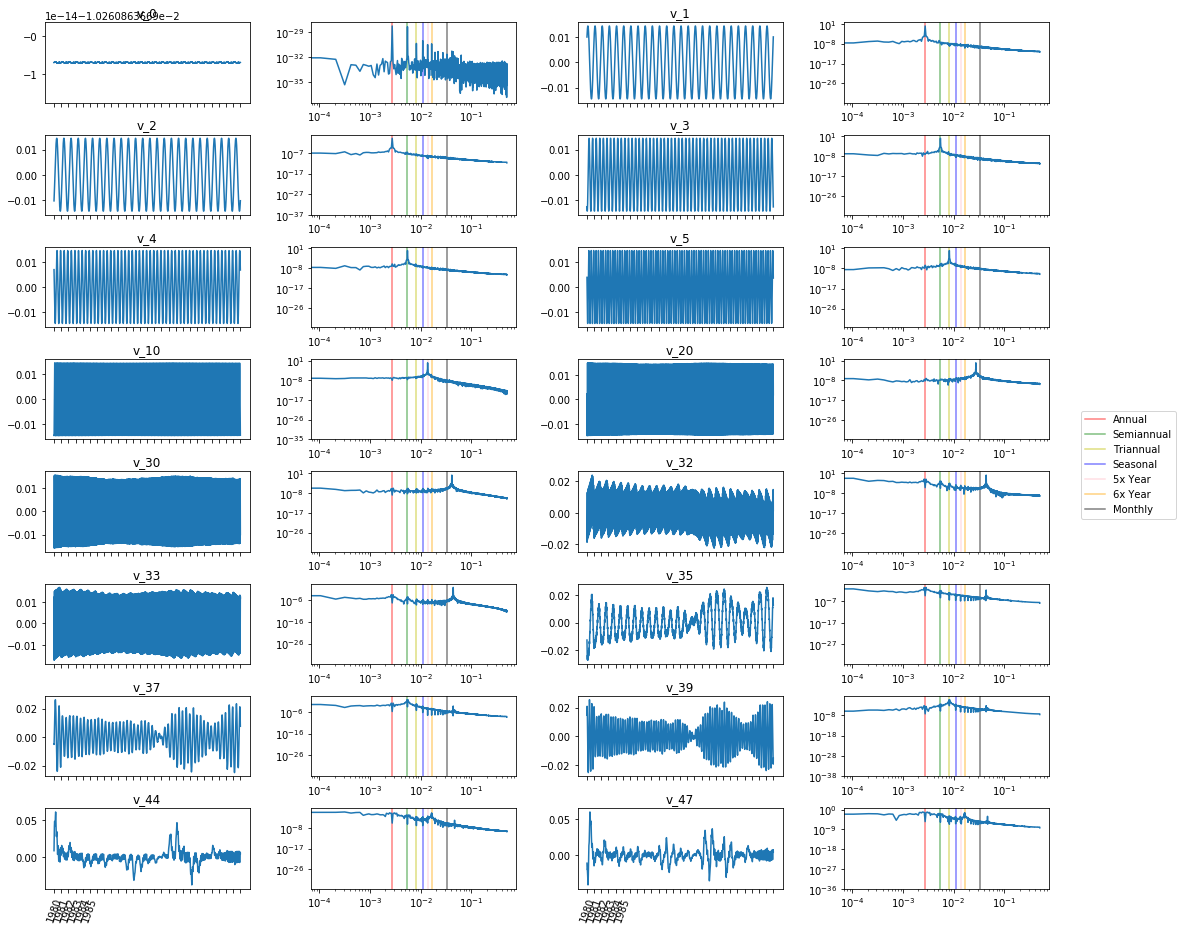

In [60]:
# Frequencies plot
list_vector = [0, 1, 2, 3, 4, 5, 10, 20, 30, 32, 33, 35, 37, 39, 44, 47]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 47:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

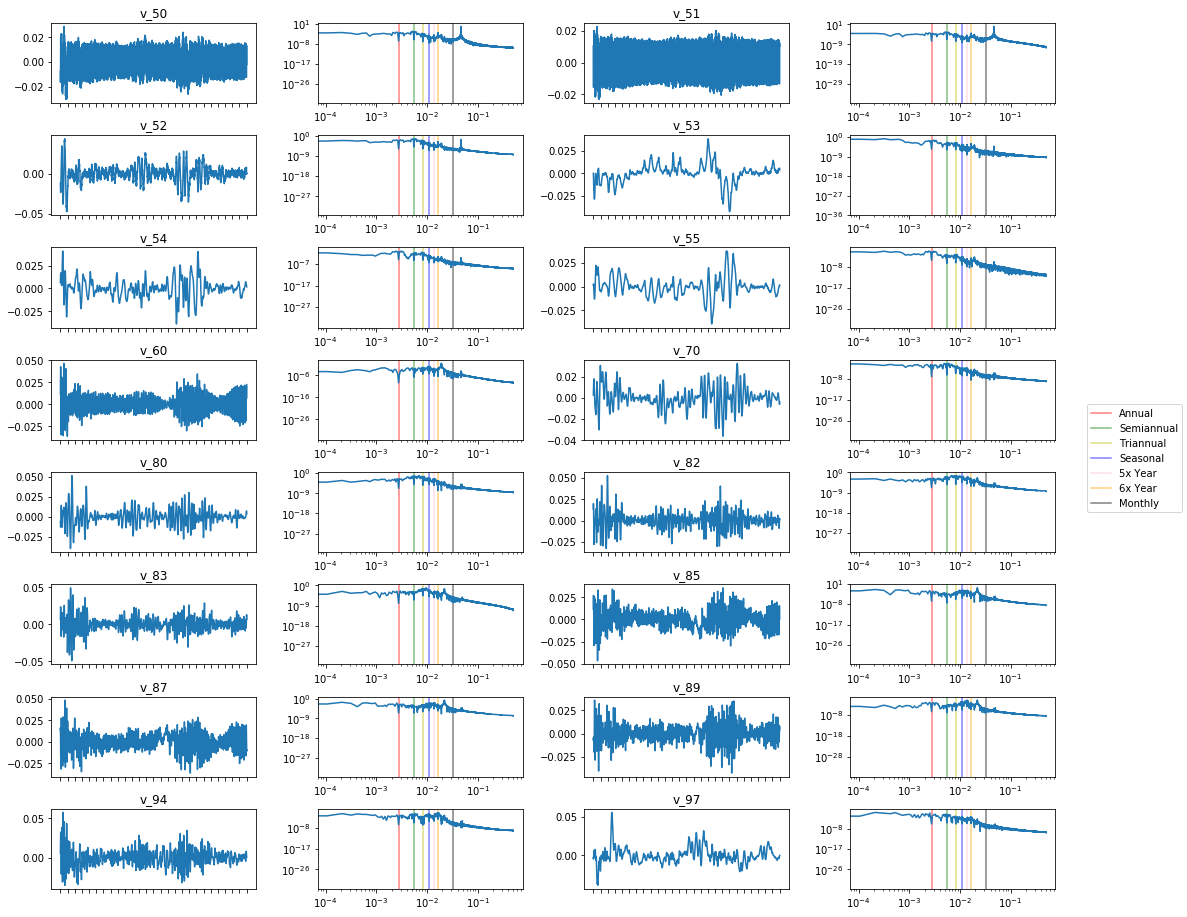

In [61]:
# Frequencies plot
list_vector = [50, 51, 52, 53, 54, 55, 60, 70, 80, 82, 83, 85, 87, 89, 94, 97]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 47:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

### Laplace-Beltrami Operator (slow)

In [18]:
def build_Laplace_Beltrami_operator_sparse_slow(kernel_mat):
    #Equivalent to kernel_mat = csr_matrix(kernel_mat / (kernel_mat.sum(axis=1)[:, None] * kernel_mat.sum(axis=0)[None, :]))
    d = kernel_mat.sum(axis=1).ravel()
    e = kernel_mat.sum(axis=0).ravel()
    arr = np.zeros(kernel_mat.data.shape[0])
    for pos, i, j, v in zip(tqdm_notebook(range(kernel_mat.data.shape[0])), kernel_mat.row, kernel_mat.col, kernel_mat.data):
        arr[pos] = v / (d[0, i] * e[0, j])

    # Equivalent to kernel_mat = kernel_mat / kernel_mat.sum(axis=1)
    kernel_mat = coo_matrix((arr, (kernel_mat.row, kernel_mat.col)))
    c = kernel_mat.sum(axis=1).ravel()
    for pos, i, j in zip(tqdm_notebook(range(kernel_mat.data.shape[0])), kernel_mat.row, kernel_mat.col):
        arr[pos] /= c[0, i]

    kernel_mat = coo_matrix((arr, (kernel_mat.row, kernel_mat.col)))
    return kernel_mat

In [ ]:
L2 = build_Laplace_Beltrami_operator_sparse_slow(test_sym.tocoo())

A Jupyter Widget

In [ ]:
check_symmetric(L2.todense())

In [246]:
for row, col, value in zip(L2.row[:50], L2.col[:50], L2.data[:50]):
    print("({0}, {1}) {2}".format(row, col, value))

(0, 1) 0.01265007296042431
(0, 2) 0.007005674548282126
(0, 3) 0.004858053839696734
(0, 4) 0.0037490076005141384
(0, 5) 0.0030472922521966868
(0, 6) 0.002569615009467547
(0, 7) 0.002206645827794581
(0, 8) 0.0019073721896862368
(0, 9) 0.001641325126971033
(0, 10) 0.0014065911264291011
(0, 11) 0.0011965022978643173
(0, 12) 0.0010085813426982052
(0, 13) 0.0008434087596886333
(0, 14) 0.0006999763541199267
(0, 15) 0.000576317819551113
(0, 16) 0.000468962866102254
(0, 17) 0.00037592748459783784
(0, 18) 0.00029684451292716677
(0, 19) 0.00023145992301621275
(0, 20) 0.00017806547787220056
(0, 21) 0.00013537679064024898
(0, 22) 0.00010223005861364058
(0, 23) 7.649753200387082e-05
(0, 24) 5.658486408543648e-05
(0, 25) 4.148256514639912e-05
(0, 26) 3.0179739901873545e-05
(0, 27) 2.1732872747189244e-05
(0, 28) 1.5505108816061784e-05
(0, 29) 1.0905891996128671e-05
(0, 30) 7.548172099536551e-06
(0, 31) 5.15738939069684e-06
(0, 32) 3.5153368665371275e-06
(0, 33) 2.3868556840474586e-06
(0, 34) 1.6073449

In [247]:
# Eigendecomposition of the Laplacian - keep only the real part
w_k, v_k = eigs(L2, k=100, which='LM')
w_k = np.real(w_k)
v_k = np.real(v_k)

In [144]:
indx = np.argsort(w_k)[::-1][:100]

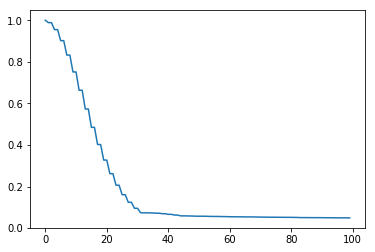

In [248]:
plt.plot(w_k[:100])

In [139]:
w_k = w_k[indx]
v_k = v_k[:, indx]

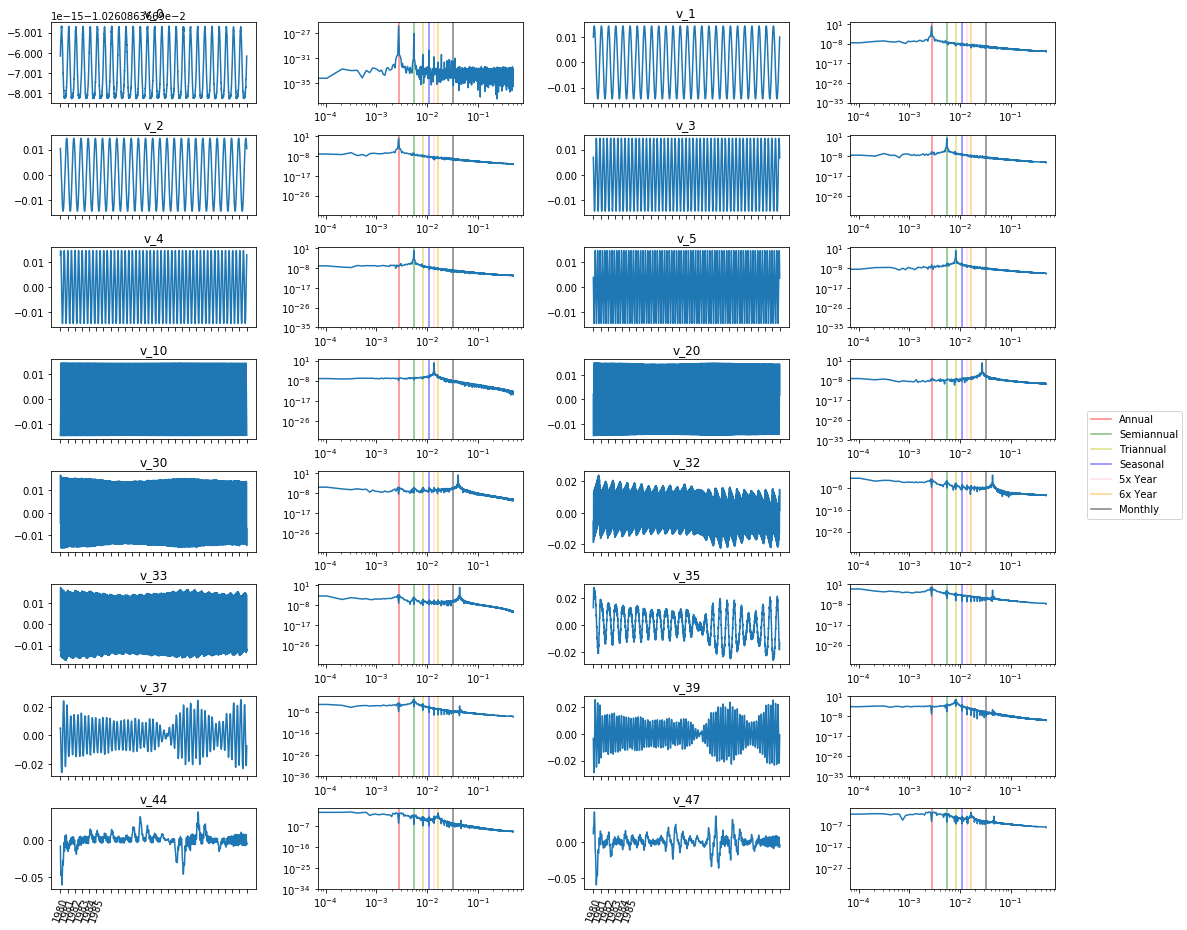

In [249]:
# Frequencies plot
list_vector = [0, 1, 2, 3, 4, 5, 10, 20, 30, 32, 33, 35, 37, 39, 44, 47]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 47:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

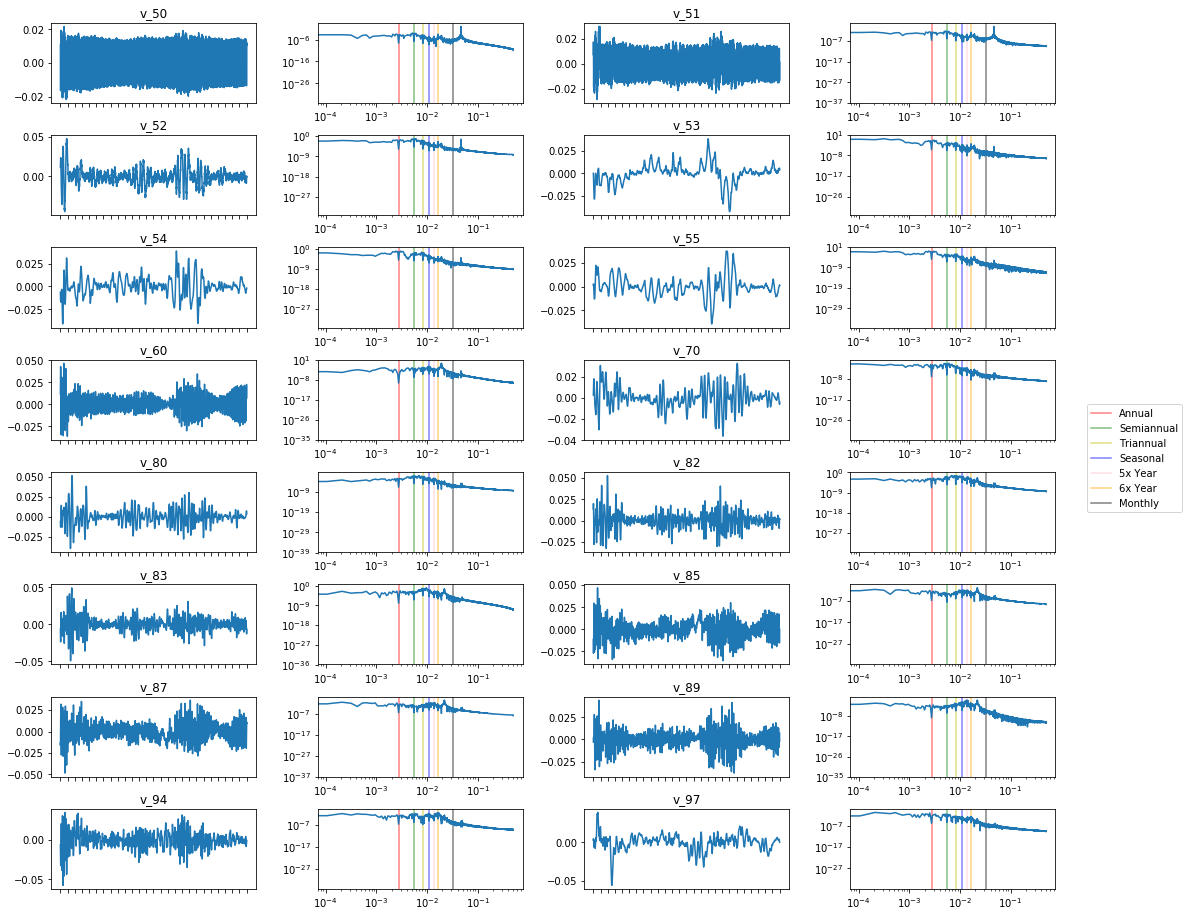

In [250]:
# Frequencies plot
list_vector = [50, 51, 52, 53, 54, 55, 60, 70, 80, 82, 83, 85, 87, 89, 94, 97]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 47:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

### USING NON SPARSE METHOD

In [ ]:
W = nlsa_kernel.todense()

In [200]:
check_symmetric(W)

True

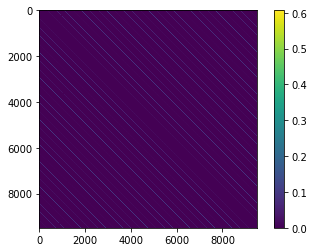

In [173]:
plt.imshow(W)
plt.colorbar()

In [204]:
L3 = mat_helper.build_Laplace_Beltrami_operator(W)

In [205]:
L3[:50, :50]

matrix([[ 1.        , -0.01265007, -0.00700567, ...,  0.        ,
          0.        ,  0.        ],
        [-0.01263725,  1.        , -0.01247828, ...,  0.        ,
          0.        ,  0.        ],
        [-0.0069954 , -0.01247263,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         -0.01210657, -0.00674042],
        [ 0.        ,  0.        ,  0.        , ..., -0.012107  ,
          1.        , -0.01211037],
        [ 0.        ,  0.        ,  0.        , ..., -0.00674083,
         -0.01211069,  1.        ]])

In [206]:
L3.shape

(9498, 9498)

In [207]:
# Eigendecomposition of the Laplacian - keep only the real part
w_k, v_k = eigs(L3, k=100, which='SM')
w_k = np.real(w_k)
v_k = np.real(v_k)

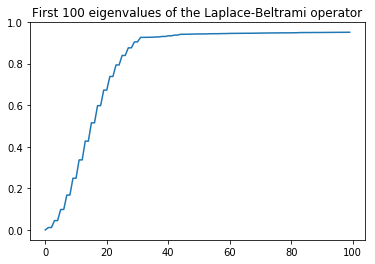

In [208]:
# Eigenvalue plot
plt.title('First 100 eigenvalues of the Laplace-Beltrami operator')
plt.plot(w_k[:100])
plt.show()

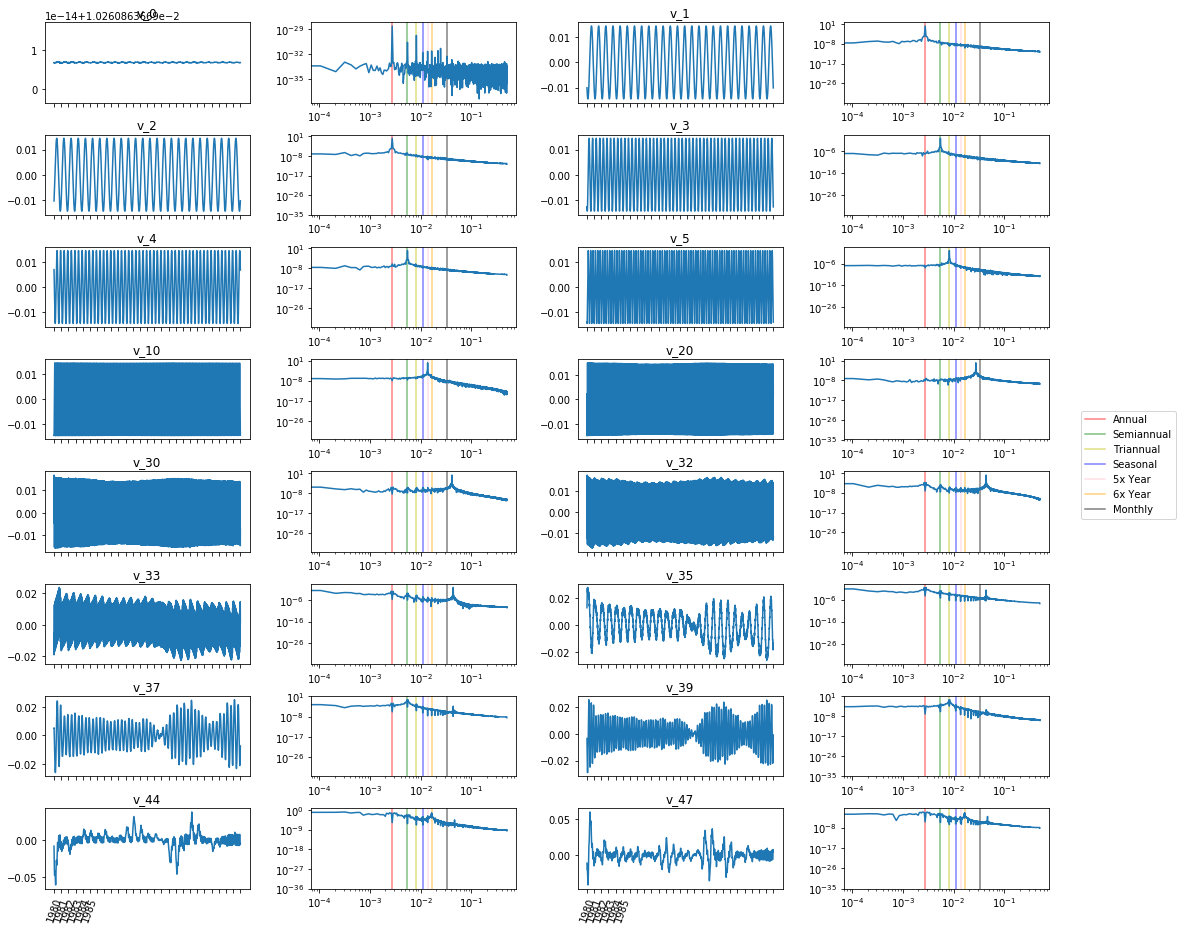

In [209]:
# Frequencies plot
list_vector = [0, 1, 2, 3, 4, 5, 10, 20, 30, 32, 33, 35, 37, 39, 44, 47]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 47:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()

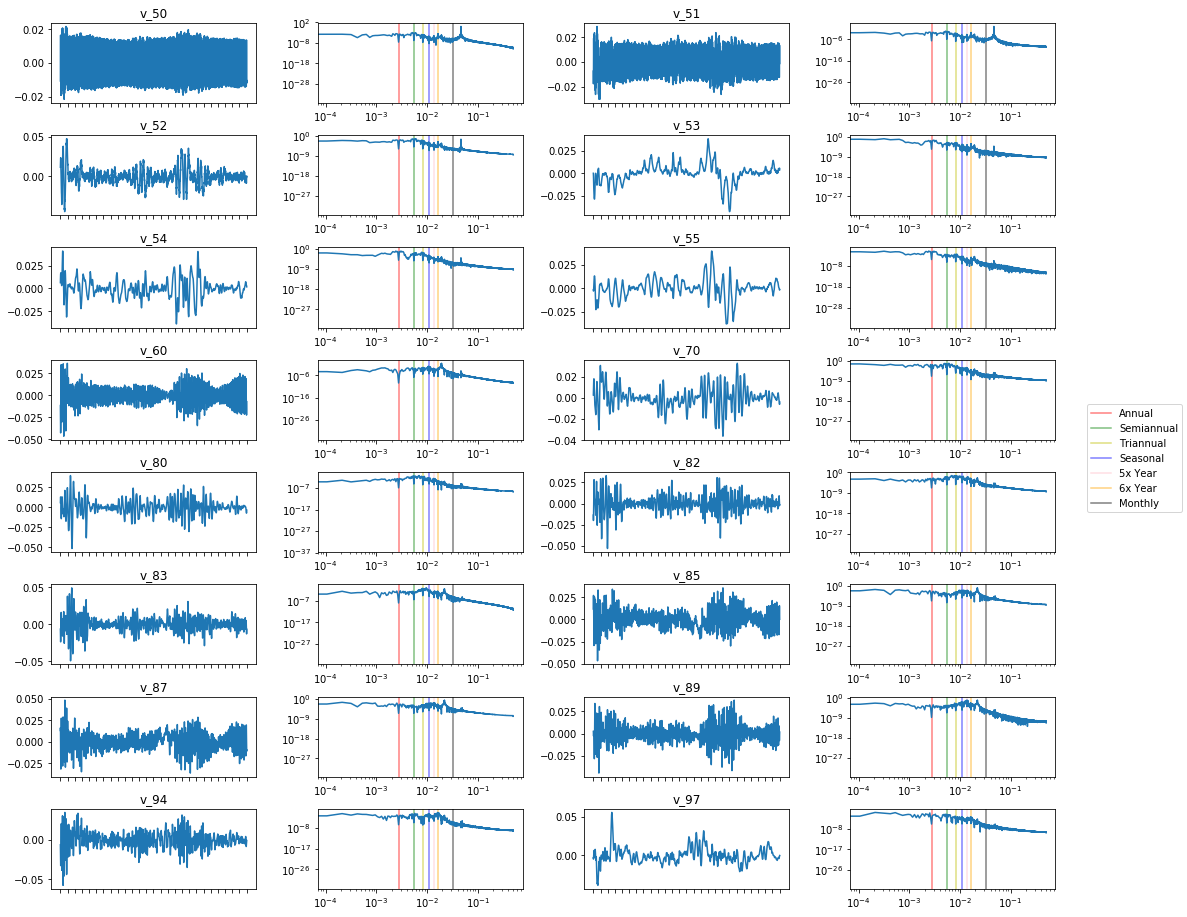

In [210]:
# Frequencies plot
list_vector = [50, 51, 52, 53, 54, 55, 60, 70, 80, 82, 83, 85, 87, 89, 94, 97]
my_xticks = np.arange(1980, 1986, 1)
fig = plt.figure(figsize=(18,18))
ind = 1
for i in list_vector:
    ax = plt.subplot(9, 4, ind)
    ax.set_xticks(np.arange(0, len(v_k[:, 0]), 365))
    
    if i == 44 or i == 47:
        ax.set_xticklabels(my_xticks, rotation='70')
    else:
        ax.set_xticklabels(['', '', '', '', '', ''], rotation='70')
        
    ind += 1
    plt.title('v_'+str(i))
    plt.plot(v_k[:, i])
    
    plt.subplot(9, 4, ind)
    ind += 1
    f, Pxx_den = signal.periodogram(np.real(v_k[:, i]))
    #l1 = plt.axvline(x=1/(365*11), color='grey', alpha=0.5) #11y
    l2 = plt.axvline(x=1/365, color='r', alpha=0.5) #1y
    l3 = plt.axvline(x=1/(365/2), color='g', alpha=0.5) #6m
    l4 = plt.axvline(x=1/(365/3), color='y', alpha=0.5) #4m
    l5 = plt.axvline(x=1/(365/4), color='b', alpha=0.5) #3m
    l6 = plt.axvline(x=1/(365/5), color='pink', alpha=0.5) #2.4m
    l7 = plt.axvline(x=1/(365/6), color='orange', alpha=0.5) #2m
    l8 = plt.axvline(x=1/(365/12), color='black', alpha=0.5)
    plt.loglog(f, Pxx_den)
    
plt.subplots_adjust(hspace=0.4, wspace = 0.3)
fig.legend((l2, l3, l4, l5, l6, l7, l8), ('Annual', 'Semiannual', 'Triannual', 'Seasonal', '5x Year', '6x Year', 'Monthly'), 'center right')
plt.show()